In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import csv
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [19]:
#read the data into list
dt=2
path = 'csv files with data/04-trial5.csv'
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    time = [row[0] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    f1 = [row[1] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    f2 = [row[2] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t1 = [row[3] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h1 = [row[4] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t2 = [row[5] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h2 = [row[6] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t3 = [row[7] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h4 = [row[8] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    af = [row[9] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t4 = [row[10] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    wm = [row[11] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t5 = [row[12] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h3 = [row[13] for row in reader]

In [20]:
filter_len = 65
filter_order = 3
del time[0]
time = list(map(int,time))
del f1[0]
f1 = list(map(float,f1))
del f2[0]
f2 = list(map(float,f2))
del t1[0]
t1 = list(map(float,t1))
del h1[0]
h1 = list(map(float,h1))
del t2[0]
t2 = list(map(float,t2))
del h2[0]
h2 = list(map(float,h2))
del t3[0]
t3 = list(map(float,t3))
t3 = savgol_filter(t3,filter_len,filter_order)  # smoothing filter of fourth order
del h4[0]
h4 = list(map(float,h4))
del af[0]
af = list(map(float,af))
af = savgol_filter(af,filter_len,filter_order)  # smoothing filter of fourth order
del t4[0]
t4 = list(map(float,t4))
del wm[0]
wm = list(map(float,wm))
del t5[0]
t5 = list(map(float,t5))
del h3[0]
h3 = list(map(float,h3))
h3 = savgol_filter(h3,filter_len,filter_order)  # smoothing filter of fourth order
er=np.empty((len(t5)))

for i in range(1,len(h3),1): #evaporation rate, in ml/h. This is the Y value that we want to fit and predict
    # evaporation rate must be calculated to amount of water leaving the towel
    # for that the measurement h3 is calibrated to weight of water
    er[i] = (h3[i]-h3[i-1])/dt  # evaporation rate is the difference between two timestamps
er[0] = er[1]

4.8140054184406836e-05


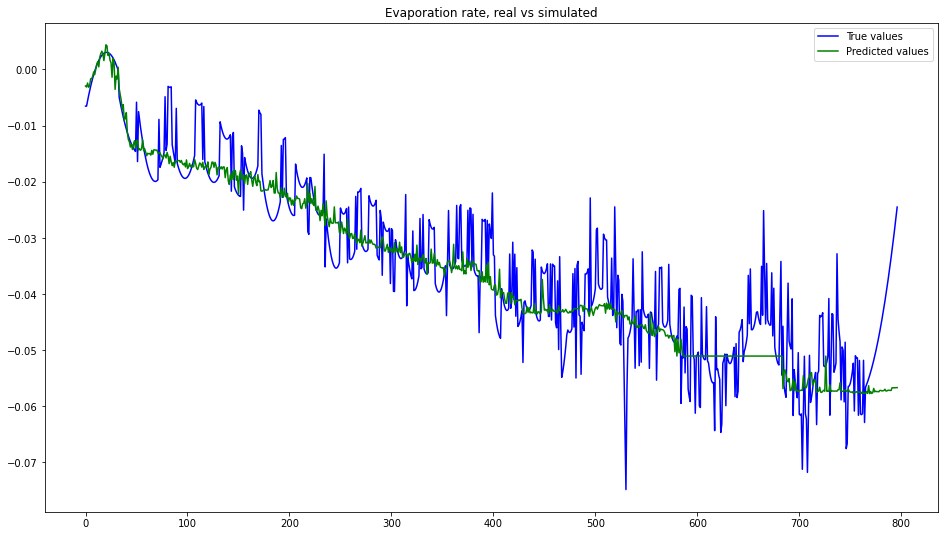

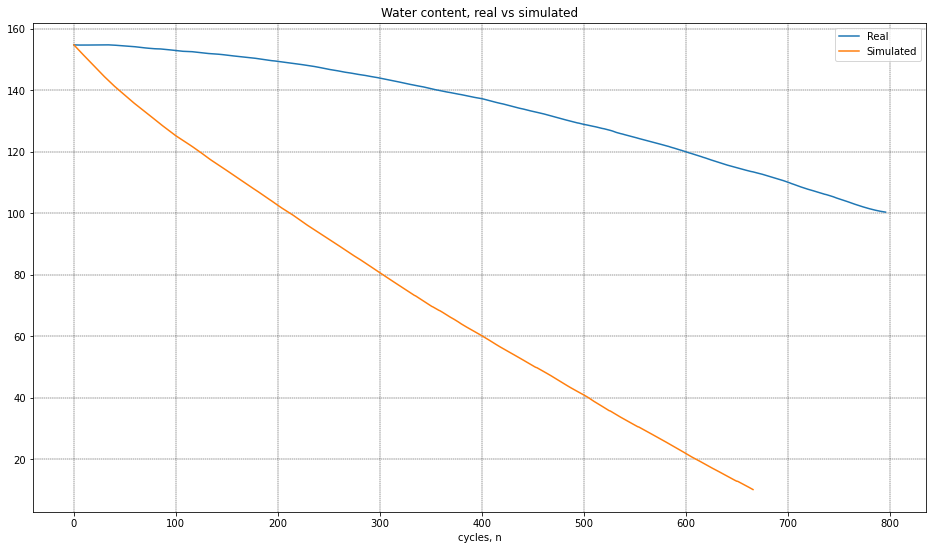

In [21]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(10)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10)
# ])
column_names = ['timestamp','f1','f2','t1','h1','t2','h2','t3','h4','af','t4','wm','t5','h3','datetime']
dataset = pd.read_csv('csv files with data/04-trial5.csv',header=0, names=column_names)
# dataset.drop(dataset.index[0])
dataset = dataset[:len(er)]
dataset['er'] = er
train_x = dataset[['t1', 'h1', 't2', 'h2', 't3', 'h4', 'af', 't4', 't5', 'h3']].to_numpy()
train_y = dataset[['er']].to_numpy()
model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[train_x.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
# model.summary()

history = model.fit(train_x, train_y, epochs=1000, validation_split = 0.1, verbose=0)
predicted_er = model.predict(train_x)
print(mean_squared_error(predicted_er,train_y))
fig, ax = plt.subplots(1,1,figsize=(16,9))
plt.plot(train_y,'b', label = 'True values')
plt.plot(predicted_er,'g', label = 'Predicted values')
plt.legend()
ax.set_title('Evaporation rate, real vs simulated')
plt.show()

####### SIMULATION #######
h3_sim = np.zeros(len(h3))
h3_sim[0] = h3[0] # same initial condition
for i in range(1,len(h3),1):
    condition = np.atleast_2d(np.array(list((t1[i], h1[i], t2[i], h2[i], t3[i], h4[i], af[i], t4[i], t5[i], h3_sim[i]))))
#     condition = np.atleast_2d(np.array(list((t1[i], h1[i], t3[i], h4[i], af[i], t4[i], t5[i], h3_sim[i]))))
    
    predicted = model.predict(condition)
    h3_sim[i] = h3_sim[i-1] + predicted*dt # integration step
    if h3_sim[i] < 10:
        h3_sim = h3_sim[0:i]
        break
    if h3_sim[i] > 500:
        h3_sim = h3_sim[0:i]
        break

# Plot
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.set_title('Water content, real vs simulated')
ax.plot(h3, label = "Real")
ax.plot(h3_sim, label = "Simulated")
ax.legend()
ax.set_xlabel('cycles, n'), ax.grid(linestyle='--',linewidth='0.4', color='black')
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
plt.show()